# Implementing the ideas of mixup

In part 1 of my report, I began discussing the ideas presented in "mixup: Beyond Empirical Risk Minimization."  In this paper, the authors present the mixup vicinal distribution as a possible substitute for the delta functions used in normal empirical risk minimization.  They also mention what I have been calling the Gaussian vicinal distribution that was first proposed in the paper "Vicinal Risk Minimization" by Chapelle, et al.  In part 2 of my report, I will be implementing these two distributions on a custom ResNet-inspired network using the CIFAR-10 dataset.  I will be experimenting with the hyperparameters introduced by each distribution.  In mixup, the proportion of each of two original images that ends up in a mixed up image ($\lambda$) is assumed to follow a Beta distribution with a single parameter $\alpha$.  In the Gaussian case, the noise added to the image is assumed to be Normal with variance $\sigma^2$.  Thus, I will see how the accuracy of the network is affected by changes in $\alpha$ when using the mixup distribution; and likewise, I will see what happens when I change $\sigma^2$ when using the Gaussian distribution.

But first, I will discuss the construction of the network.

## The Network

The network I built was inspired by the ResNets.  The first two layers are 3x3 convolutions to get the number of channels to 32.  Each convolution is followed by a batch norm and a ReLU activation function.  Then there are 16 residual blocks.  Following the results of "Identity mappings in deep residual networks" (He, Kaiming, et al), the structure in each residual block is as follows: \
\
Batch Norm $\rightarrow$ ReLU $\rightarrow$ Convolution (3x3) $\rightarrow$ Batch Norm $\rightarrow$ ReLU $\rightarrow$ Convolution (3x3).
\
\
There is a residual connection allowing the network to skip any residual block.  Following the advice of the paper, there is nothing on the residual connection.  The changes in resolution and the number of channels from block to block mimics on a smaller scale the structure of the ResNet in "Deep residual learning for image recognition" (He, Kaiming, et al).  The 16 residual blocks are in four groups.  In the first block of each group (except the first group), the first convolution doubles the number of channels.  Therefore, with each group of blocks, the channels increase from 32 to 64 to 128 to 256.  In the second and third blocks, a stride of 2 is added to the first convolution, so that by the beginning of the fourth block, the resolution has been decreased to 4x4.  To keep the dimensions consistent, the residual connection is padded with zeroes when the channels increase.  When the resolution decreases, max pooling with a stride of 2 is used to decrease the resolution of the residual connection.  The network ends with global average pooling and a linear layer before classification.

## Training

The network was trained 11 seperate times.  Each time the batch size is 128, the learning rate is 0.001 and the number of epochs is 40.  They are grouped as follows:
\
\
(1) Vicinal Distribution:  None \
(2) Vicinal Distribution:  Gaussian \
&emsp; (a) $\sigma^{2}$ = 0.01 \
&emsp; (b) $\sigma^{2}$ = 0.02 \
&emsp; (c) $\sigma^{2}$ = 0.03 \
&emsp; (d) $\sigma^{2}$ = 0.04 \
(3) Vicinal Distribution:  Mixup \
&emsp; (a) $\alpha$ = 0.1 \
&emsp; (b) $\alpha$ = 0.2 \
&emsp; (c) $\alpha$ = 0.3 \
&emsp; (d) $\alpha$ = 0.4 \
(4) Vicinal Distribution:  Gaussian Scheduled - $\sigma^{2}$ is increased by 0.01 every 10 epochs \
(5) Vicinal Distribution:  Mixup Scheduled - $\alpha$ is increased by 0.1 every 10 epochs.

## Aside:  Difficulties constructing adaptive kernel width

In "Vicinal Risk Minimization," the authors discuss how adapting the variance of the Gaussian vicinal distributions to each data point can improve a model's performance.  This idea is known as "adaptive kernel width."  They state that in areas of feature space where there is little data, it is important to have a broader kernel width, while in areas of the space with more data, it is important to have a more narrow kernel width.  The reason for this is that when you have data closely clustered together, and each data point has a similar label, you can take advantage of the closer data points to estimate the local density of the data more accurately.  When there is less data, you need a broader width to capture similar data points from which to extrapolate a density.  After reading this, I thought it was important to try and implement this in my network.  The authors of the paper suggest making the kernel a function of the distances between some fixed number of nearest neighbors.  Therefore, my plan was to use the BallTree library from scikit learn's nearest neighbor library.  The tree would be populated by all the training data.  The tree would then be queried for every image in every batch to get the distances to the nearest 5 neighbors.  These distances were to be averaged and multiplied by a global factor to bring the kernel within a reasonable range of about 0.01 to 0.05.  However, upon testing this with a single training batch, I discovered that it took about 10 seconds per batch to query the tree.  Since there is about 300 batches in the training data, it added  almost an hour per epoch to implement this technique.  I attempted to decrease the time complexity by reducing the number of neighbors to 3 and to construct the tree with fewer training examples, but this dropped the time down to 40 minutes per epoch, which was still too much.  Therefore, I had to abandon the idea of using adaptive kernels.  The consequences of this will be discussed further below.

## Coding up the network

In [1]:
#Importing libraries

import torch
from torchvision import transforms, datasets
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid
import pandas as pd
from skimage.util import random_noise
import random

In [123]:
#Importing CIFAR-10 data

train_data, val_data = random_split(datasets.CIFAR10(root='./data', train=True, download=True,
                                                   transform=transforms.ToTensor()), [40000, 10000])
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())


Files already downloaded and verified
Files already downloaded and verified


In [124]:
#Setting batch size and constructing dataloaders

batch_size=128

train_dl = DataLoader(train_data, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_data, batch_size, num_workers=4, pin_memory=True)
test_dl = DataLoader(test_data, batch_size, num_workers=4, pin_memory=True)

In [125]:
#Functions for moving tensors/model to GPU

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [126]:
device = get_default_device()
device

device(type='cuda')

In [127]:
#Creating functions for training and validating model

#Note: alpha and variance should be lists of four floats.  This allows the possibility of increasing these parameters
#during training

class ImageClassificationBase(nn.Module):   
    
 #Added functionality to training_step from previous report.  When function is called, must specify data augmentation method

    def training_step(self, batch, variance, alpha, data_aug_type='None'):
        if data_aug_type == 'None':
            images, labels = batch
            out = self(images)
            loss = F.cross_entropy(out, labels)
        if data_aug_type == 'Gaussian':
            images, labels = img_to_gauss_img(batch, variance)
            out = self(images)                  
            loss = F.cross_entropy(out, labels)
        if data_aug_type == 'mixup':
            images, labels1, labels2, lam = mixup_imgs(batch, alpha)
            out = self(images)
            loss = lam*F.cross_entropy(out, labels1)+(1-lam)*F.cross_entropy(out, labels2)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    
        loss = F.cross_entropy(out, labels)   
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

#Functions for computing validation and test accuracy   


def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def test_accuracy(model, test_loader):
    corr = 0
    poss = 0
    for batch in test_loader:
        images, labels = batch
        out = model(images)
        _, preds = torch.max(out, dim=1)
        t = torch.sum(preds == labels).item()
        poss += len(images)
        corr += t
    return corr/poss

#Functions for adding Gaussian Noise to images and performing mixup 

def img_to_gauss_img(batch, variance):
    images, labels = batch
    arr = random_noise(images.cpu().numpy(), mode='gaussian', mean=0, var=variance, clip=True)
    noisy_images = torch.from_numpy(arr).float()
    noisy_images = to_device(noisy_images, device)
    return noisy_images, labels

def mixup_imgs(batch, alpha):
    images, labels = batch
    new_images = []
    labels1 = []
    labels2 = []
    for i in range(0,images.size()[0]):
        rand1 = random.randint(0,images.size()[0]-1)
        rand2 = random.randint(0,images.size()[0]-1)
        img1 = images[rand1]
        img2 = images[rand2]
        alpha = 0.2
        lam = np.random.beta(alpha, alpha)
        new_img = lam*img1 + (1-lam)*img2
        new_images.append(new_img)
        labels1.append(labels[rand1])
        labels2.append(labels[rand2])
    new_imgs_tens = torch.stack(new_images)
    new_labels1_tens = torch.stack(labels1)
    new_labels2_tens = torch.stack(labels2)
    return new_imgs_tens, new_labels1_tens, new_labels2_tens, lam


        

In [128]:
#Main construction of the network.  ResBlock takes parameters (channels in, channel increment, pooling stride)

class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16,32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            ResBlock(32, 1, 2), #Images reduced to 18x18
            ResBlock(32, 1, 1), 
            ResBlock(32, 1, 1),
            ResBlock(32, 1, 1),
            ResBlock(32, 2, 2), #Images reduced to 9x9
            ResBlock(64, 1, 1), 
            ResBlock(64, 1, 1),
            ResBlock(64, 1, 1),
            ResBlock(64, 2, 2), #Images reduced to 4x4
            ResBlock(128, 1, 1),
            ResBlock(128, 1, 1),
            ResBlock(128, 1, 1),
            ResBlock(128, 2, 1),
            ResBlock(256, 1, 1),
            ResBlock(256, 1, 1),
            ResBlock(256, 1, 1),
            nn.AvgPool2d(4),
            nn.Flatten(),
            nn.Linear(256,10))
        
    def forward(self, xb):
        return self.network(xb)


In [129]:
#Defining the Residual Blocks

class ResBlock(nn.Module):
    def __init__(self, channels_in, inc, stride):
        super().__init__()
        self.channels_in = channels_in
        self.inc = inc
        self.stride = stride
        self.adjust_resolution = True
        self.adjust_channels = True
        if self.inc == 1:
            self.adjust_channels = False
        if stride == 1:
            self.adjust_resolution = False
        self.bn1 = nn.BatchNorm2d(self.channels_in)
        self.relu1 = nn.ReLU()
        self.conv1 = nn.Conv2d(self.channels_in, self.channels_in*self.inc, kernel_size=3, stride=self.stride, padding=1)
        self.bn2 = nn.BatchNorm2d(self.channels_in*inc)
        self.relu2 = nn.ReLU()
        self.conv2 = nn.Conv2d(self.channels_in*inc, self.channels_in*self.inc, kernel_size=3, stride=1, padding=1)
        self.maxp = nn.MaxPool2d(1, stride=self.stride)

        
    def forward(self, x):
        residual = x
        out = self.bn1(x)
        out = self.relu1(out)
        out = self.conv1(out)
        out = self.bn2(out)
        out = self.relu1(out)
        out = self.conv2(out)
        if self.adjust_resolution:
            residual = self.maxp(x)
        if self.adjust_channels:
            residual = F.pad(residual, (0, 0, 0, 0, 0, self.channels_in))
        out += residual
        out = self.relu2(out)
        return out   



In [130]:
#Functions for evaluating model and running testing/validation

@torch.no_grad()
def evaluate(model, val_loader, val=False):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    if val==False:
        return model.validation_epoch_end(outputs)
    else:
        k = kernel_validation(model, val_loader)
        return k

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD, 
        variance=[0.01, 0.01, 0.01, 0.01], alpha=[0.2, 0.2, 0.2, 0.2], data_aug_type='None'):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            
            #Training broken down into 4 periods so that variance or alpha can be increased during training
            
            if epoch < 10:
                loss = model.training_step(batch, variance[0], alpha[0], data_aug_type)
            if epoch >=10 and epoch < 20:
                loss = model.training_step(batch, variance[1], alpha[1], data_aug_type)
            if epoch >=20 and epoch < 30:
                loss = model.training_step(batch, variance[2], alpha[2], data_aug_type)
            if epoch >=30 and epoch < 40:
                loss = model.training_step(batch, variance[3], alpha[3], data_aug_type)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [131]:
#Setting global parameters and loading data to GPU

num_epochs = 40
opt_func = torch.optim.Adam
lr = 0.001
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [ ]:
#Training with Gaussian vicinal distributions

gauss_results = {}
gauss_acc = {}
for i in range(1,5):
    model = ResNet()
    to_device(model, torch.device('cuda'))
    var = i*0.01
    gauss_results[str(var)] = fit(num_epochs, lr, model, train_dl, val_dl, opt_func, data_aug_type='Gaussian', variance=[var,var,var,var])
    gauss_acc[str(var)] = test_accuracy(model, test_dl)
    torch.cuda.empty_cache()


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch [0], train_loss: 1.6908, val_loss: 1.6418, val_acc: 0.4181
Epoch [1], train_loss: 1.2668, val_loss: 1.2709, val_acc: 0.5576
Epoch [2], train_loss: 1.0370, val_loss: 1.1933, val_acc: 0.6015
Epoch [3], train_loss: 0.8869, val_loss: 1.1787, val_acc: 0.6100
Epoch [4], train_loss: 0.7895, val_loss: 1.0998, val_acc: 0.6392
Epoch [5], train_loss: 0.7082, val_loss: 1.0721, val_acc: 0.6513
Epoch [6], train_loss: 0.6372, val_loss: 1.0258, val_acc: 0.6761
Epoch [7], train_loss: 0.5818, val_loss: 0.9437, val_acc: 0.6908
Epoch [8], train_loss: 0.5408, val_loss: 0.8208, val_acc: 0.7258
Epoch [9], train_loss: 0.4647, val_loss: 0.8433, val_acc: 0.7278
Epoch [10], train_loss: 0.4192, val_loss: 0.8387, val_acc: 0.7385
Epoch [11], train_loss: 0.3697, val_loss: 1.0203, val_acc: 0.7058
Epoch [12], train_loss: 0.3341, val_loss: 0.9538, val_acc: 0.7305
Epoch [13], train_loss: 0.2984, val_loss: 1.0413, val_acc: 0.7177
Epoch [14], train_loss: 0.2740, val_loss: 1.0114, val_acc: 0.7252
Epoch [15], train_lo

In [ ]:
#Training with mixup vicinal distributions

mixup_results = {}
mixup_acc = {}
for i in range(1,5):
    model = ResNet()
    to_device(model, torch.device('cuda'))
    al = i*0.1
    mixup_results[str(al)] = fit(num_epochs, lr, model, train_dl, val_dl, opt_func, data_aug_type='mixup', alpha=[al,al,al,al])
    mixup_acc[str(al)] = test_accuracy(model, test_dl)
    torch.cuda.empty_cache()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 2.2559, val_loss: 2.0746, val_acc: 0.2788
Epoch [1], train_loss: 2.1401, val_loss: 1.8888, val_acc: 0.3366
Epoch [2], train_loss: 2.0950, val_loss: 1.7097, val_acc: 0.4247
Epoch [3], train_loss: 2.0532, val_loss: 1.5796, val_acc: 0.5336
Epoch [4], train_loss: 2.0276, val_loss: 1.5666, val_acc: 0.5190
Epoch [5], train_loss: 2.0071, val_loss: 1.4593, val_acc: 0.5755
Epoch [6], train_loss: 1.9779, val_loss: 1.3665, val_acc: 0.6104
Epoch [7], train_loss: 1.9559, val_loss: 1.3050, val_acc: 0.6403
Epoch [8], train_loss: 1.9387, val_loss: 1.2885, val_acc: 0.6709
Epoch [9], train_loss: 1.9234, val_loss: 1.2708, val_acc: 0.6732
Epoch [10], train_loss: 1.9036, val_loss: 1.2636, val_acc: 0.6768
Epoch [11], train_loss: 1.8952, val_loss: 1.2018, val_acc: 0.7091
Epoch [12], train_loss: 1.8857, val_loss: 1.2336, val_acc: 0.6749
Epoch [13], train_loss: 1.8762, val_loss: 1.1785, val_acc: 0.7322
Epoch [14], train_loss: 1.8724, val_loss: 1.1995, val_acc: 0.7216
Epoch [15], train_lo

In [ ]:
#Training with no data augmentation

model = ResNet()
to_device(model, torch.device('cuda'))
baseline = fit(num_epochs, lr, model, train_dl, val_dl, opt_func, data_aug_type='None')
baseline_acc = test_accuracy(model, test_dl)
torch.cuda.empty_cache()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 1.6264, val_loss: 1.3617, val_acc: 0.4864
Epoch [1], train_loss: 1.1291, val_loss: 1.0833, val_acc: 0.6147
Epoch [2], train_loss: 0.8813, val_loss: 0.9061, val_acc: 0.6882
Epoch [3], train_loss: 0.7138, val_loss: 0.9145, val_acc: 0.6961
Epoch [4], train_loss: 0.5917, val_loss: 0.8573, val_acc: 0.7130
Epoch [5], train_loss: 0.5096, val_loss: 0.7259, val_acc: 0.7635
Epoch [6], train_loss: 0.4269, val_loss: 0.7025, val_acc: 0.7697
Epoch [7], train_loss: 0.3492, val_loss: 0.7714, val_acc: 0.7582
Epoch [8], train_loss: 0.2953, val_loss: 0.7649, val_acc: 0.7725
Epoch [9], train_loss: 0.2329, val_loss: 0.7540, val_acc: 0.7862
Epoch [10], train_loss: 0.1992, val_loss: 0.7467, val_acc: 0.7916
Epoch [11], train_loss: 0.1579, val_loss: 0.7774, val_acc: 0.7876
Epoch [12], train_loss: 0.1259, val_loss: 0.9553, val_acc: 0.7650
Epoch [13], train_loss: 0.1130, val_loss: 0.8884, val_acc: 0.7832
Epoch [14], train_loss: 0.1002, val_loss: 0.9656, val_acc: 0.7782
Epoch [15], train_lo

In [ ]:
#Training with Gaussian Noise

model = ResNet()
to_device(model, torch.device('cuda'))
gauss_sched_results = fit(num_epochs, lr, model, train_dl, val_dl, opt_func, data_aug_type='Gaussian', variance=[0.01, 0.02, 0.03, 0.04])
gauss_sched_acc = test_accuracy(model, test_dl)
torch.cuda.empty_cache()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 1.7063, val_loss: 1.4671, val_acc: 0.4598
Epoch [1], train_loss: 1.2724, val_loss: 1.3336, val_acc: 0.5152
Epoch [2], train_loss: 1.0347, val_loss: 1.0264, val_acc: 0.6358
Epoch [3], train_loss: 0.8829, val_loss: 0.9613, val_acc: 0.6685
Epoch [4], train_loss: 0.7712, val_loss: 0.8970, val_acc: 0.6885
Epoch [5], train_loss: 0.6870, val_loss: 0.8720, val_acc: 0.7070
Epoch [6], train_loss: 0.6158, val_loss: 1.1689, val_acc: 0.6370
Epoch [7], train_loss: 0.5573, val_loss: 0.9602, val_acc: 0.6881
Epoch [8], train_loss: 0.4987, val_loss: 0.8754, val_acc: 0.7171
Epoch [9], train_loss: 0.4388, val_loss: 0.8559, val_acc: 0.7289
Epoch [10], train_loss: 0.4852, val_loss: 1.0352, val_acc: 0.6929
Epoch [11], train_loss: 0.4363, val_loss: 1.0114, val_acc: 0.6949
Epoch [12], train_loss: 0.3923, val_loss: 1.0755, val_acc: 0.6904
Epoch [13], train_loss: 0.3590, val_loss: 1.1228, val_acc: 0.6804
Epoch [14], train_loss: 0.3236, val_loss: 1.0390, val_acc: 0.7064
Epoch [15], train_lo

In [ ]:
#Training with Mixup

model = ResNet()
to_device(model, torch.device('cuda'))
mixup_sched_results = fit(num_epochs, lr, model, train_dl, val_dl, opt_func, data_aug_type='mixup', alpha=[0.1, 0.2, 0.3, 0.4])
mixup_sched_acc = test_accuracy(model, test_dl)
torch.cuda.empty_cache()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 2.2424, val_loss: 1.9099, val_acc: 0.2964
Epoch [1], train_loss: 2.1280, val_loss: 1.8527, val_acc: 0.3372
Epoch [2], train_loss: 2.0921, val_loss: 1.6814, val_acc: 0.4587
Epoch [3], train_loss: 2.0645, val_loss: 1.6196, val_acc: 0.4985
Epoch [4], train_loss: 2.0477, val_loss: 1.6219, val_acc: 0.5054
Epoch [5], train_loss: 2.0209, val_loss: 1.5353, val_acc: 0.5568
Epoch [6], train_loss: 1.9943, val_loss: 1.4031, val_acc: 0.6094
Epoch [7], train_loss: 1.9710, val_loss: 1.4492, val_acc: 0.6370
Epoch [8], train_loss: 1.9475, val_loss: 1.4093, val_acc: 0.5919
Epoch [9], train_loss: 1.9322, val_loss: 1.3267, val_acc: 0.6572
Epoch [10], train_loss: 1.9179, val_loss: 1.3225, val_acc: 0.6512
Epoch [11], train_loss: 1.9144, val_loss: 1.3118, val_acc: 0.6593
Epoch [12], train_loss: 1.8931, val_loss: 1.1877, val_acc: 0.6910
Epoch [13], train_loss: 1.8820, val_loss: 1.1753, val_acc: 0.7171
Epoch [14], train_loss: 1.8727, val_loss: 1.1465, val_acc: 0.7149
Epoch [15], train_lo

In [ ]:
#Saving Results

import csv
keys = gauss_results['0.01'][0].keys()
with open('gauss_results_1.csv', 'w', newline='')  as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(gauss_results['0.01'])
keys = gauss_results['0.02'][0].keys()
with open('gauss_results_2.csv', 'w', newline='')  as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(gauss_results['0.02'])
keys = gauss_results['0.03'][0].keys()
with open('gauss_results_3.csv', 'w', newline='')  as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(gauss_results['0.03'])
keys = gauss_results['0.04'][0].keys()
with open('gauss_results_4.csv', 'w', newline='')  as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(gauss_results['0.04'])



In [ ]:
keys = mixup_results['0.1'][0].keys()
with open('mixup_results_1.csv', 'w', newline='')  as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(mixup_results['0.1'])
keys = mixup_results['0.2'][0].keys()
with open('mixup_results_2.csv', 'w', newline='')  as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(mixup_results['0.2'])
keys = mixup_results['0.30000000000000004'][0].keys()
with open('mixup_results_3.csv', 'w', newline='')  as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(mixup_results['0.30000000000000004'])
keys = mixup_results['0.4'][0].keys()
with open('mixup_results_4.csv', 'w', newline='')  as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(mixup_results['0.4'])

In [ ]:
with open('mixup_acc.csv', 'w') as csvfile:
    mixup_list = [mixup_acc]
    writer = csv.DictWriter(csvfile, fieldnames = mixup_acc.keys())
    writer.writeheader()
    writer.writerows(mixup_list)

with open('gauss_acc.csv', 'w') as csvfile:
    gauss_list = [gauss_acc]
    writer = csv.DictWriter(csvfile, fieldnames = gauss_acc.keys())
    writer.writeheader()
    writer.writerows(gauss_list)

In [ ]:
keys = gauss_sched_results[0].keys()
with open('gauss_sched_results.csv', 'w', newline='')  as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(gauss_sched_results)
keys = mixup_sched_results[0].keys()
with open('mixup_sched_results.csv', 'w', newline='')  as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(mixup_sched_results)
wiht open('baseline_results.csv', w, newline='') as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(baseline)

In [ ]:
sched_acc = [{'mixup_sched_acc': mixup_sched_acc, 'gauss_sched_acc': gauss_sched_acc}]
keys = sched_acc[0].keys()
with open('sched_acc.csv', 'w', newline='')  as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(sched_acc)
base_acc = [{'baseline_acc': baseline_acc}]
keys = base_acc[0].keys()
with open('baseline_acc.csv', 'w', newline='')  as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(base_acc)


## The Results

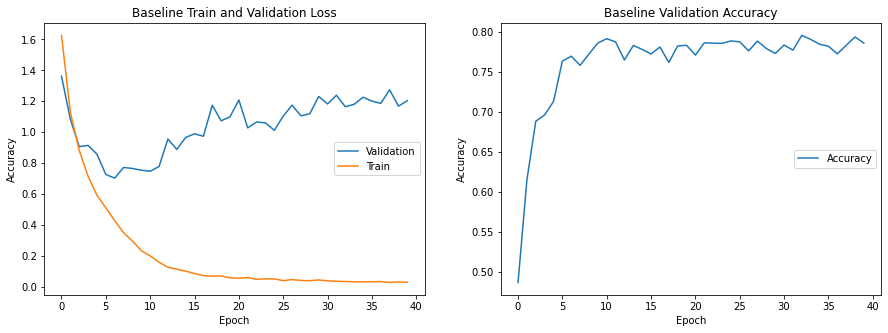

In [149]:
#Plotting baseline results

df0 = pd.read_csv("baseline_results.csv")
fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].plot(range(40), df0['val_loss'], label="Validation")
axs[0].plot(df0['train_loss'], label="Train")
axs[0].set(xlabel="Epoch")
axs[0].set(ylabel="Accuracy")
axs[0].set(title="Validation Accuracy")
axs[0].legend(loc='right')
axs[0].set(title="Baseline Train and Validation Loss")
axs[1].plot(range(40), df0['val_acc'], label='Accuracy')
axs[1].set(xlabel="Epoch")
axs[1].set(ylabel="Accuracy")
axs[1].set(title="Baseline Validation Accuracy")
axs[1].legend(loc='right')
plt.show()


In [122]:
#Getting baseline accuracy

df00 = pd.read_csv("baseline_acc.csv")
df00

,Baseline Accuracy
0,0.7981


The results of training with no vicinal distribution (I shall refer to it as baseline) are displayed above.  We can see that the training loss went below the validation loss after less than 5 epochs.  By about 10 epochs, the validation accuracy levels off just below 0.80.  The test accuracy was 0.7981.

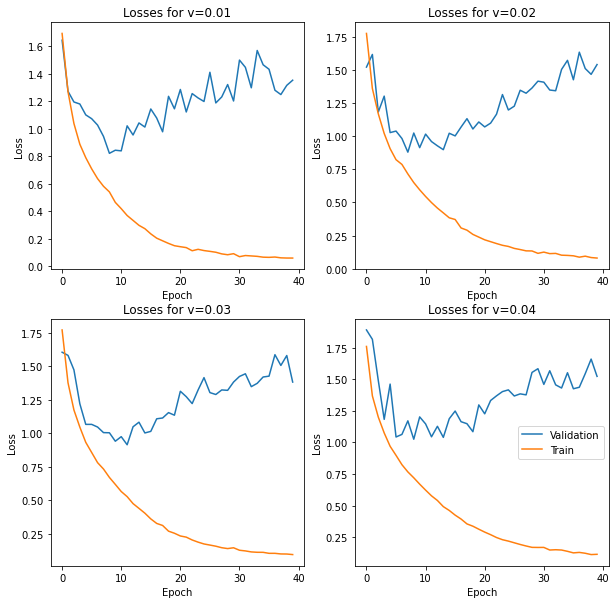

In [137]:
#Plotting Gaussian Noise results

fig, axs = plt.subplots(2, 2, figsize=(10,10))
df1 = pd.read_csv("gauss_results_1.csv")
df2 = pd.read_csv("gauss_results_2.csv")
df3 = pd.read_csv("gauss_results_3.csv")
df4 = pd.read_csv("gauss_results_4.csv")
axs[0, 0].plot(range(40), df1['val_loss'], label="Validation")
axs[0, 0].plot(df1['train_loss'], label="Train")
axs[0, 0].set_title('Losses for v=0.01')
axs[0, 1].plot(range(40), df2['val_loss'], label="Validation")
axs[0, 1].plot(df2['train_loss'], label="Train")
axs[0, 1].set_title('Losses for v=0.02')
axs[1, 0].plot(range(40), df3['val_loss'], label="Validation")
axs[1, 0].plot(df3['train_loss'], label="Train")
axs[1, 0].set_title('Losses for v=0.03')
axs[1, 1].plot(range(40), df4['val_loss'], label="Validation")
axs[1, 1].plot(df4['train_loss'], label="Train")
axs[1, 1].legend(loc='right')
axs[1, 1].set_title('Losses for v=0.04')

for ax in axs.flat:
    ax.set(xlabel='Epoch', ylabel='Loss')

The training and validation losses for each run of the Gaussian vicinal distributions are graphed above.  The results for each run are all very similar.  The training loss behaved similarly to the baseline case.  The validation loss after 10 epochs seems to drift upward in a way that didn't quite occur with the baseline case.  This is a clear sign that the network is minimizing training loss at the expense of validation loss, meaning the network is failing to generalize and is beginning to memorize the training data.

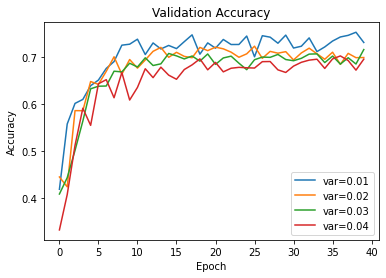

In [98]:
#Plotting Gaussian Validation Accuracies

plt.plot(range(40), df1['val_acc'], label='var=0.01')
plt.plot(df2['val_acc'], label='var=0.02')
plt.plot(df3['val_acc'], label='var=0.03')
plt.plot(df4['val_acc'], label='var=0.04')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend(loc='lower right')
plt.show()

In [94]:
#Gettting Gaussing Testing Accuracies

df_gauss_acc = pd.read_csv("gauss_acc.csv")
df_gauss_acc

,var=0.01,var=0.02,var=0.03,var=0.04
0,0.7315,0.6988,0.7016,0.6808


The validation accuracies are graphed above for each variance.  The validation accuracies all level off around 0.70 after about 10 epochs.  Increasing the variance seems to have the effect of decreasing validation accuracy.  The testing accuracies are displayed in the table above.  When the variance was the lowest at 0.01, the network performed the best.  The other three variances resulted in comparable results with the variance at 0.04 performing the worst.  Overall, each of the four networks performed much worse than baseline.

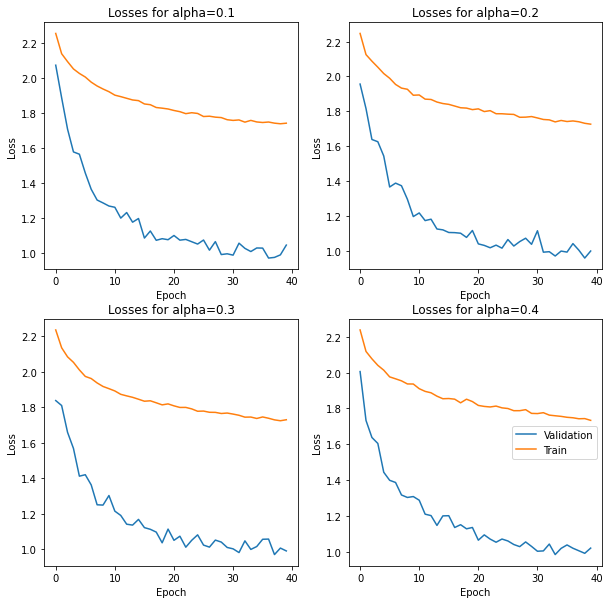

In [143]:
#Plotting Mixup Results

fig, axs = plt.subplots(2, 2, figsize=(10,10))
df5 = pd.read_csv("mixup_results_1.csv")
df6 = pd.read_csv("mixup_results_2.csv")
df7 = pd.read_csv("mixup_results_3.csv")
df8 = pd.read_csv("mixup_results_4.csv")
axs[0, 0].plot(range(40), df5['val_loss'], label="Validation")
axs[0, 0].plot(df5['train_loss'], label="Train")
axs[0, 0].set_title('Losses for alpha=0.1')
axs[0, 1].plot(range(40), df6['val_loss'], label="Validation")
axs[0, 1].plot(df6['train_loss'], label="Train")
axs[0, 1].set_title('Losses for alpha=0.2')
axs[1, 0].plot(range(40), df7['val_loss'], label="Validation")
axs[1, 0].plot(df7['train_loss'], label="Train")
axs[1, 0].set_title('Losses for alpha=0.3')
axs[1, 1].plot(range(40), df8['val_loss'], label="Validation")
axs[1, 1].plot(df8['train_loss'], label="Train")
axs[1, 1].legend(loc='right')
axs[1, 1].set_title('Losses for alpha=0.4')

for ax in axs.flat:
    ax.set(xlabel='Epoch', ylabel='Loss')

The graphs of the validation and training loss for the mixup networks are displayed above.  Even after 40 epochs, the training loss is still much higher than the validation loss.  Clearly, these networks would have benefited from more training.

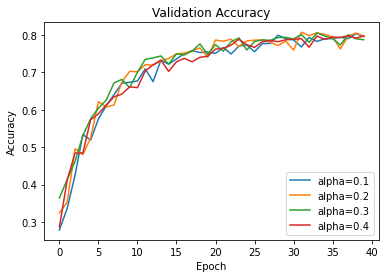

In [101]:
#Plotting Mixup validation accuracy

plt.plot(range(40), df5['val_acc'], label='alpha=0.1')
plt.plot(df6['val_acc'], label='alpha=0.2')
plt.plot(df7['val_acc'], label='alpha=0.3')
plt.plot(df8['val_acc'], label='alpha=0.4')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend(loc='lower right')
plt.show()

In [93]:
#Getting mixup testing accuracy

df_mixup_acc = pd.read_csv("mixup_acc.csv")
df_mixup_acc

,alpha=0.1,alpha=0.2,alpha=0.3,alpha=0.4
0,0.7918,0.7878,0.7883,0.796


The results for the validation accuracies for the mixup networks are graphed above.  Each network is performing almost equally.  There is still a slight increase in accuracy after 40 epochs, indicating that more training is necessary.  The testing accuracies are displayed in the table above.  The network with alpha=0.4 performed the best, even beating the baseline case.  The accuracies are close to one another.  Considering that more training would have resulted in higher accuracies, not much can be gleaned from the testing results.  It is possible that any one of them would have out performed the others if given enough time.

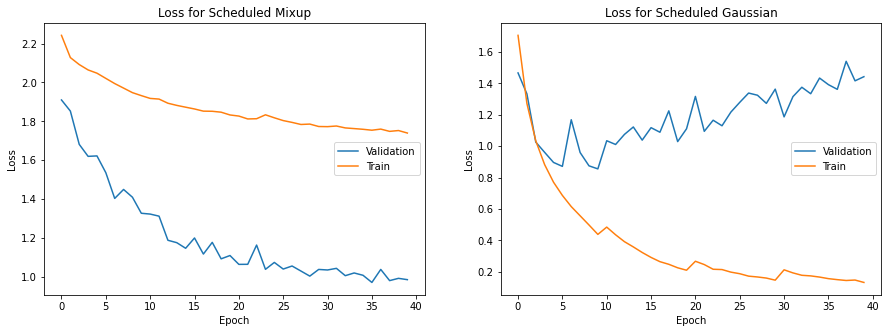

In [146]:
#Plotting Scheduled Results

fig, axs = plt.subplots(1, 2, figsize=(15,5))
df9 = pd.read_csv("mixup_sched_results.csv")
df10 = pd.read_csv("gauss_sched_results.csv")
axs[0].plot(range(40), df9['val_loss'], label="Validation")
axs[0].plot(df9['train_loss'], label="Train")
axs[0].set_title('Loss for Scheduled Mixup')
axs[0].legend(loc='right')
axs[1].plot(range(40), df10['val_loss'], label="Validation")
axs[1].plot(df10['train_loss'], label="Train")
axs[1].set_title('Loss for Scheduled Gaussian')
axs[1].legend(loc='right')


for ax in axs.flat:
    ax.set(xlabel='Epoch', ylabel='Loss')

The loss results for the scheduled mixup and Gaussian networks are graphed above.  Recall that for these networks, the hyperparameter of interest was increased every 10 epochs (by 0.01 for the variance in the Gaussian case, and 0.1 for alpha in the mixup case).  This was not something that was attempted in the mixup paper.  However, I thought it would be interesting to try.  The idea behind this experiment was that by gradually increaseing the variance or alpha, the network would have time to slowly adapt to the increasingly novel data.  It is interesting to see that the training loss jumps exactly every 10 epochs in the Gaussian case, which is a sign that the network is unfamiliar with the more noisy images.  A similar but more subtle phenomenon is occuring in the mixup case.   

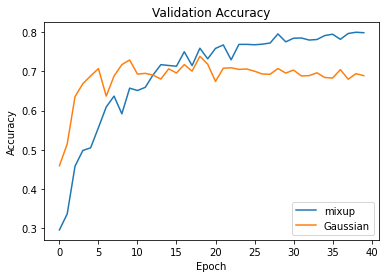

In [103]:
#Plotting Scheduled Validation Accuracy

plt.plot(range(40), df9['val_acc'], label='mixup')
plt.plot(df10['val_acc'], label='Gaussian')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend(loc='lower right')
plt.show()

In [148]:
#Getting scheduled testing accuracy

df_sched_acc = pd.read_csv("sched_acc.csv")
df_sched_acc

,Scheduled Mixup Acc,Scheduled Gaussian Acc
0,0.7984,0.6838


The validation accuracies for both scheduled methods are graphed above.  Clearly the mixup network is outperforming the Gaussian network.  In fact, the validation accuracy of the mixup network is still steadily increasing after 40 epochs.  In addition, the scheduled mixup network performed the best on the testing data out of all the networks tested in this report.

## Discussion

Overall, the mixup networks performed well while the Gaussian networks performed poorly.  The scheduled mixup network even outperformed the baseline.  If I were able to train the networks for longer, it is clear that all of the mixup networks would have outperformed the baseline case, indicating that mixup might improve the performance of residual networks.  There are a number of reasons why the Gaussian networks did not perform well.  The first is that, since I was unable to implement the adaptive kernels, the variance was the same for every image in the dataset.  This implicitly assumes that images in one class are equally as similar to each other as the images in another class.  This assumption might be false.  Maybe cats tend to look alike while trucks, on the other hand, tend to be more diverse.  This relates to the second and more problematic fault of the Gaussian vicinal distribution:  it makes faulty assumptions about the nature of images.  The Gaussian networks assume that what separates two similar images is the mere random deviation of a collection of pixels.  It is true that a picture of a cat is still a picture of a cat even if noise is added.  However, this may be false if enough noise is added.  And, more importantly, this is not what is essentialy meant when we say two images are similar.  For example, an image of a cat sitting on a couch is similar to an image of a cat outside in the grass.  Even more simply, an image of a cat is similar to a reflected or rotated picture of a cat.  These notions of similarity are not embodied by the Gaussian networks.  The end result, instead, seems to be that these networks learn superficial, uninformative differences introduced by the noise which don't generalize to the training data.  Mixup, on the other hand, makes a possibly correct assumption about the nature of images, namely that linear combinations of images should result in linear combinations of labels.  Implementing this notion in a network helps structure the geometry of the space of possible functions mapping inputs to outputs, which in turn may help the network achieve higher accuracy.  As I noted in the previous part of this report, it is somewhat absurd to think about things like a linear combination of images or labels, as this doesn't seem to be relevant when humans identify objects.  However, my claim from before about how mixup forces a network to learn from examples without memorizing the training data seems to be justified by the results of the above experiments.  The fact that the validation loss is higher than the training loss indicates that the model is not overfitting.  The slow convergence of the network indicates that the network is being forced to deal with difficult examples.  Since the network is always penalized no matter what classification it makes, it can't take any shortcuts.  There is no reward for memorizing the training data.

## Conclusion

In conclusion, it is clear that using the Gaussian vicinal distribution is ill-suited for image classification.  The more noise that was added to images, the worse the network performed.  Mixup, on the other hand, performed very well.  While I was unable to pin down an optimal value for alpha as the network still needed more time to train, the indication after 40 epochs is that all four values of alpha would outperform baseline.  In addition, the scheduled mixup network performed the best, indicating that slowly ramping up the novelty of training data may be advantageous.

If I had more time, I would have liked to have implemented the adaptive kernels.  This may have helped the Gaussian networks to perform better.  I am also interested to see how mixup might perform on other types of networks.